In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision
%matplotlib inline

In [ ]:
train_data_ref = np.load('/content/gdrive/MyDrive/НИС и курсовые/cifar102_train.npz')
test_data_ref = np.load('/content/gdrive/MyDrive/НИС и курсовые/cifar102_test.npz')

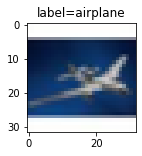

In [ ]:
plt.figure(figsize=(2,2))
ind = 3047
plt.imshow(train_data_ref['images'][ind])
plt.title(f"label={train_data_ref['label_names'][train_data_ref['labels'][ind]]}")
plt.show()

In [ ]:
train_data_ref['label_names']

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [ ]:
class RefDataset(torch.utils.data.Dataset):
    def __init__(self, train, transforms):
        super().__init__()
        self.transforms = transforms
        if train:
            self.images = train_data_ref['images']
            self.labels = train_data_ref['labels']
        else:
            self.images = test_data_ref['images']
            self.labels = test_data_ref['labels']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            'image': self.transforms(self.images[idx]),
            'label': self.labels[idx]
        }

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

In [ ]:
train_ref_dataset = RefDataset(train=True, transforms=transform)
test_ref_dataset = RefDataset(train=False, transforms=transform)

In [ ]:
train_data_shift = torchvision.datasets.CIFAR10(root='./cifar_train', train=True, download=True, transform=transform)
test_data_shift = torchvision.datasets.CIFAR10(root='./cifar_test', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar_train/cifar-10-python.tar.gz to ./cifar_train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar_test/cifar-10-python.tar.gz to ./cifar_test


In [ ]:
train_data_shift.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
len(train_data_shift)

50000

In [ ]:
len(train_ref_dataset)

10000

In [ ]:
batch_size = 64

train_ref_dataloader = torch.utils.data.DataLoader(train_ref_dataset, batch_size=batch_size, shuffle=True)
test_ref_dataloader = torch.utils.data.DataLoader(test_ref_dataset, batch_size=batch_size, shuffle=False)
train_shift_dataloader = torch.utils.data.DataLoader(train_data_shift, batch_size=batch_size, shuffle=True)
test_shift_dataloader = torch.utils.data.DataLoader(test_data_shift, batch_size=batch_size, shuffle=False)

In [ ]:
def get_weights(model):
    params = [p.data.cpu().clone().numpy().ravel() for p in model.parameters()]
    return np.concatenate(params)

def weights_to_model(model, w):
    offset = 0

    for parameter in model.parameters():
        size = np.prod(parameter.size())
        value = w[offset:offset+size].reshape(parameter.size())
        parameter.data.copy_(torch.from_numpy(value))
        offset += size
    return 

def linear_interpolation(model1, model2, alpha):
    weights1 = get_weights(model1)
    weights2 = get_weights(model2)
    return alpha * weights1 + (1 - alpha) * weights2

In [ ]:
from torchvision.models import resnet18


class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.backbone(x)


def freeze_layers(to_freeze, model):
    for i, child in enumerate(model.backbone.children()):
            if i < to_freeze:
                for param in child.parameters():
                    param.requires_grad = False

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

0.7982


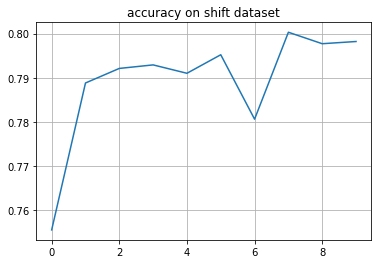

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm


set_random_seed(3047)


ZERO_SHOT_MODEL = SimpleModel().to(device)
freeze_layers(6, ZERO_SHOT_MODEL)
opt = torch.optim.Adam(ZERO_SHOT_MODEL.parameters())

num_epochs = 10

val_accs = []
for epoch in range(num_epochs):
    ZERO_SHOT_MODEL.train(True)
    for batch in tqdm(train_shift_dataloader):
        data = batch[0].to(device)
        labels = batch[1].to(device)

        preds = ZERO_SHOT_MODEL(data)
        loss = F.cross_entropy(preds, labels)

        loss.backward()
        opt.step()
        opt.zero_grad()

    accs = []
    ZERO_SHOT_MODEL.train(False)
    with torch.no_grad():
        for batch in test_shift_dataloader:
            data = batch[0].to(device)
            labels = batch[1]

            preds = ZERO_SHOT_MODEL(data)
            ans = torch.argmax(preds.data.to('cpu'), dim=-1)
            accs.append((ans == labels).sum().numpy())
    
    clear_output(wait=True)
    print(np.sum(accs) / len(test_data_shift))
    val_accs.append(np.sum(accs) / len(test_data_shift))
    plt.plot(val_accs)
    plt.title('accuracy on shift dataset')
    plt.grid()
    plt.show()

In [ ]:
def finetune_model(model, opt, num_epochs=10):
    model.train(True)
    for epoch in range(num_epochs):
        for batch in tqdm(train_ref_dataloader):
            data = batch['image'].to(device)
            labels = batch['label'].to(device)

            logits = model(data)
            loss = F.cross_entropy(logits, labels)

            loss.backward()
            opt.step()
            opt.zero_grad()
    
        accs = []
        model.train(False)
        with torch.no_grad():
            for batch in test_ref_dataloader:
                data = batch['image'].to(device)
                labels = batch['label']

                logits = model(data).data.to('cpu').argmax(dim=-1)
                accs.append(np.mean((logits == labels).numpy()))
        print(f"val acc {np.mean(accs)}", flush=True)


def reset_bn(module):
    if issubclass(module.__class__, nn.modules.batchnorm._BatchNorm):
        module.reset_running_stats()


def fix_batchnorm_stats(model, mode):
    model.train(True)
    model.apply(reset_bn)
    if mode == 'shift':
        for batch in train_shift_dataloader:
            data = batch[0].to(device)
            model(data)
    else:
        for batch in train_ref_dataloader:
            data = batch['image'].to(device)
            model(data)

In [ ]:
def get_point(model):
    fix_batchnorm_stats(model, mode='shift')
    model.train(False)
    with torch.no_grad():
        accs = []
        for batch in test_shift_dataloader:
            data = batch[0].to(device)
            labels = batch[1]

            preds = model(data)
            ans = torch.argmax(preds.data.to('cpu'), dim=-1)
            accs.append((ans == labels).sum().numpy())
        y = np.sum(accs) / len(test_data_shift)

    fix_batchnorm_stats(model, mode='ref')
    model.train(False)
    with torch.no_grad():
        accs = []
        for batch in test_ref_dataloader:
            data = batch['image'].to(device)
            labels = batch['label']

            preds = model(data)
            ans = torch.argmax(preds.data.to('cpu'), dim=-1)
            accs.append((ans == labels).sum().numpy())
        x = np.sum(accs) / len(test_ref_dataset)

    return x, y

In [ ]:
get_point(ZERO_SHOT_MODEL)

(0.65, 0.7965)

In [ ]:
def make_experiment(to_freeze):
    points = []
    set_random_seed(3047)

    new_model = SimpleModel().to(device)
    sd = ZERO_SHOT_MODEL.state_dict()
    new_model.load_state_dict(sd)
    freeze_layers(to_freeze, new_model)
    opt = torch.optim.Adam(new_model.parameters(), lr=1e-4)

    finetune_model(new_model, opt)
    points.append(get_point(new_model))

    for alpha in tqdm(np.linspace(0, 1, 10)):
        tmp_model = SimpleModel().to(device)
        tmp_weights = linear_interpolation(ZERO_SHOT_MODEL, new_model, alpha)
        weights_to_model(tmp_model, tmp_weights)
        points.append(get_point(tmp_model))
    return points

In [ ]:
res = {}

for to_freeze in [8, 7, 6, 5, 4]:
    print(to_freeze)
    res[to_freeze] = make_experiment(to_freeze)

8


100%|██████████| 157/157 [00:02<00:00, 77.29it/s]


val acc 0.646484375


100%|██████████| 157/157 [00:01<00:00, 84.51it/s]


val acc 0.64453125


100%|██████████| 157/157 [00:01<00:00, 82.28it/s]


val acc 0.64990234375


100%|██████████| 157/157 [00:01<00:00, 83.41it/s]


val acc 0.650390625


100%|██████████| 157/157 [00:01<00:00, 82.97it/s]


val acc 0.64892578125


100%|██████████| 157/157 [00:01<00:00, 83.72it/s]


val acc 0.64990234375


100%|██████████| 157/157 [00:01<00:00, 81.80it/s]


val acc 0.64794921875


100%|██████████| 157/157 [00:01<00:00, 85.96it/s]


val acc 0.64111328125


100%|██████████| 157/157 [00:01<00:00, 85.46it/s]


val acc 0.64697265625


100%|██████████| 157/157 [00:01<00:00, 85.60it/s]


val acc 0.64453125


100%|██████████| 10/10 [03:19<00:00, 19.96s/it]


7


100%|██████████| 157/157 [00:02<00:00, 66.76it/s]


val acc 0.64990234375


100%|██████████| 157/157 [00:02<00:00, 69.64it/s]


val acc 0.65234375


100%|██████████| 157/157 [00:02<00:00, 68.74it/s]


val acc 0.662109375


100%|██████████| 157/157 [00:02<00:00, 68.95it/s]


val acc 0.66162109375


100%|██████████| 157/157 [00:02<00:00, 69.42it/s]


val acc 0.662109375


100%|██████████| 157/157 [00:02<00:00, 68.84it/s]


val acc 0.6669921875


100%|██████████| 157/157 [00:02<00:00, 69.92it/s]


val acc 0.66455078125


100%|██████████| 157/157 [00:02<00:00, 69.17it/s]


val acc 0.66845703125


100%|██████████| 157/157 [00:02<00:00, 68.93it/s]


val acc 0.6708984375


100%|██████████| 157/157 [00:02<00:00, 70.47it/s]


val acc 0.671875


100%|██████████| 10/10 [03:17<00:00, 19.76s/it]


6


100%|██████████| 157/157 [00:02<00:00, 55.39it/s]


val acc 0.66162109375


100%|██████████| 157/157 [00:02<00:00, 56.66it/s]


val acc 0.66748046875


100%|██████████| 157/157 [00:02<00:00, 57.18it/s]


val acc 0.6787109375


100%|██████████| 157/157 [00:02<00:00, 57.54it/s]


val acc 0.67431640625


100%|██████████| 157/157 [00:02<00:00, 57.67it/s]


val acc 0.67919921875


100%|██████████| 157/157 [00:02<00:00, 57.65it/s]


val acc 0.68115234375


100%|██████████| 157/157 [00:02<00:00, 57.38it/s]


val acc 0.68603515625


100%|██████████| 157/157 [00:02<00:00, 57.76it/s]


val acc 0.68408203125


100%|██████████| 157/157 [00:02<00:00, 55.67it/s]


val acc 0.68896484375


100%|██████████| 157/157 [00:02<00:00, 56.47it/s]


val acc 0.68994140625


100%|██████████| 10/10 [03:16<00:00, 19.60s/it]


5


100%|██████████| 157/157 [00:03<00:00, 46.75it/s]


val acc 0.6728515625


100%|██████████| 157/157 [00:03<00:00, 47.38it/s]


val acc 0.6689453125


100%|██████████| 157/157 [00:03<00:00, 40.21it/s]


val acc 0.689453125


100%|██████████| 157/157 [00:03<00:00, 49.39it/s]


val acc 0.68994140625


100%|██████████| 157/157 [00:03<00:00, 48.92it/s]


val acc 0.69287109375


100%|██████████| 157/157 [00:03<00:00, 48.61it/s]


val acc 0.69091796875


100%|██████████| 157/157 [00:03<00:00, 48.19it/s]


val acc 0.697265625


100%|██████████| 157/157 [00:03<00:00, 48.38it/s]


val acc 0.689453125


100%|██████████| 157/157 [00:03<00:00, 49.83it/s]


val acc 0.693359375


100%|██████████| 157/157 [00:03<00:00, 47.96it/s]


val acc 0.69287109375


100%|██████████| 10/10 [03:16<00:00, 19.67s/it]


4


100%|██████████| 157/157 [00:03<00:00, 43.42it/s]


val acc 0.67724609375


100%|██████████| 157/157 [00:03<00:00, 45.26it/s]


val acc 0.67578125


100%|██████████| 157/157 [00:03<00:00, 44.53it/s]


val acc 0.681640625


100%|██████████| 157/157 [00:03<00:00, 43.66it/s]


val acc 0.69189453125


100%|██████████| 157/157 [00:03<00:00, 44.60it/s]


val acc 0.68798828125


100%|██████████| 157/157 [00:03<00:00, 44.24it/s]


val acc 0.69287109375


100%|██████████| 157/157 [00:03<00:00, 43.12it/s]


val acc 0.6923828125


100%|██████████| 157/157 [00:03<00:00, 44.06it/s]


val acc 0.67236328125


100%|██████████| 157/157 [00:03<00:00, 45.31it/s]


val acc 0.69091796875


100%|██████████| 157/157 [00:03<00:00, 45.02it/s]


val acc 0.68310546875


100%|██████████| 10/10 [03:16<00:00, 19.60s/it]


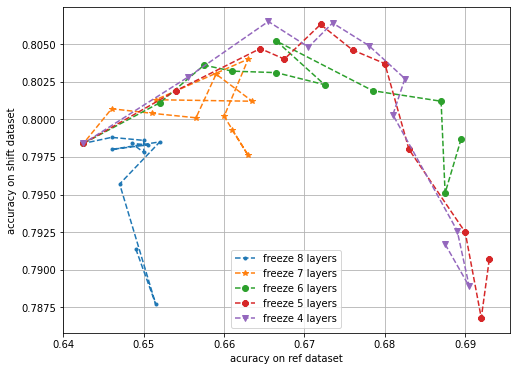

In [ ]:
plt.figure(figsize=(8, 6))
markers = {
    8: ".",
    7: "*",
    6: "o",
    5: "8",
    4: "v"
}

for freeze, points in res.items():
    xs, ys = zip(*points)
    plt.plot(xs, ys, linestyle='--', marker=markers[freeze], label=f"freeze {freeze} layers")
    plt.grid()
    plt.xlabel('acuracy on ref dataset')
    plt.ylabel('accuracy on shift dataset')
    plt.legend()